In [2]:
import ase
from ase import Atoms
from ase.build import bulk
from ase.visualize import view
from gpaw import GPAW, PW, FermiDirac
from ase.dft.dos import DOS
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ase.io import write
from ase.spacegroup import crystal

from ase.units import kJ
from ase.eos import EquationOfState
from ase.build import graphene
from dftd3.ase import DFTD3
from ase.io import read
from ase.dft.kpoints import ibz_points, bandpath
from ase.lattice.hexagonal import Graphite
from ase.visualize.plot import plot_atoms


# Diamond

Crystal structure: Diamond
Bravais lattice: face centered cubic
Lattice constant: aC = 3.57 Å
Bond length: dC = 1.54 Å
Atomic density: n = 8 /a³

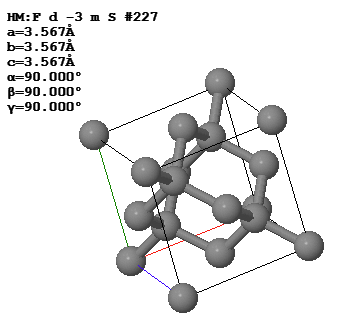

source [https://lampz.tugraz.at/~hadley/ss1/crystalstructure/structures/diamond/diamond.php]


# Graphene 

Graphene consist of a single layer of atoms arranged in a hexagonal lattice.

Crystal structure: Hexagonal
Lattice constant: aG = 2.45 Å
Bond length: dC = 1.42 Å
Atomic density: n = 2 /a²


# Graphite

Graphite is a crystalline form of the element carbon. It consists of stacked layers of graphene.

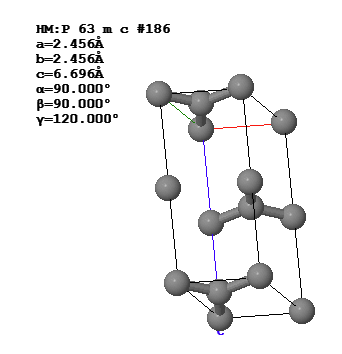

source [https://lampz.tugraz.at/~hadley/ss1/crystalstructure/structures/graphite/graphite_jsmol.php]




In [18]:
def gen_diamond(a0=3.567):
    return bulk('C', 'diamond', cubic=True, a=a0)

def calculate_eos_diamond(a0=3.567, npoints=7):
    energies = []
    volumes = []
    for scale in np.linspace(0.90, 1.10, npoints):
        diamond_atoms = gen_diamond(a0=scale*a0)
        calc = GPAW(mode=PW(300), xc='PBE', kpts=(18,18,18), txt=f'save/diamond_{a0*scale:.2f}.txt')
        diamond_atoms.calc = calc
        energy = diamond_atoms.get_potential_energy()
        energies.append(energy)
        volumes.append(diamond_atoms.get_volume()) 
    eos = EquationOfState(volumes, energies,eos='birchmurnaghan')
    eos_fit = eos.fit()
    print('Plot for Diamond')
    eos.plot('pics/Diamond_EOS.png')
    plt.show()
    return volumes,energies, eos_fit


def gen_graphene(a0=2.4549,z_spacing=6):
    # z_spacing 6 => c = 12 
    graphene_slab = graphene(a=a0, vacuum=z_spacing)
    graphene_slab.set_pbc([True, True, True])
    return graphene_slab

def calculate_eos_graphene(a0=2.4549,z_spacing=6 , npoints=7):
    energies = []
    volumes = []
    for scale in np.linspace(0.90, 1.10, npoints):
        graphite_atoms = gen_graphene(a0=a0*scale,z_spacing=z_spacing)
        calc = GPAW(mode=PW(300), xc='PBE', kpts={'size': (30, 30, 1), 'gamma': True}, txt=f'save/graphene_{a0*scale:.2f}.txt') # from k points file
        graphite_atoms.calc = calc
        energy = graphite_atoms.get_potential_energy()
        energies.append(energy)
        volumes.append(graphite_atoms.get_volume()) 
    eos = EquationOfState(volumes, energies,eos='birchmurnaghan')
    eos_fit = eos.fit()
    print('Plot for Graphene')
    eos.plot('pics/Diamond_EOS.png')
    plt.show()
    return volumes,energies, eos_fit


def gen_graphite_from_poscar():
    graphite = read('input/graphite.POSCAR', format='vasp')  
    return graphite

"""
def gen_graphite(a0=2.4549,c0=6.708):
    # Generate graphite AB-stack structure:
    graphite = Atoms('C4',
                scaled_positions=[(1 / 3.0, 1 / 3.0, 0),
                                    (2 / 3.0, 2 / 3.0, 0),
                                    (0, 0, 0.5),
                                    (1 / 3.0, 1 / 3.0, 0.5)],
                pbc=(1, 1, 1),
                cell=[(np.sqrt(3) * a0 / 2, 3 / 2.0 * a0, 0),
                        (-np.sqrt(3) * a0 / 2, 3 / 2.0 * a0, 0),
                        (0, 0, c0)])
    return graphite

"""
def gen_graphite(a0=2.4549,c0=6.708):
    graphite = Graphite(symbol='C',latticeconstant={'a':a0,'c':c0},size=(1,1,1), pbc=(1,1,1))
    return graphite


def calculate_eos_graphite(a0=2.4549,c0=6.708, npoints=7,n_c_points = 1):
    energies = []
    volumes = []
    for c_scale in np.linspace(0.90, 1.10, n_c_points):
        if n_c_points == 1:
            c_scale = 1
        for scale in np.linspace(0.90, 1.10, npoints):
            graphite_atoms = gen_graphite(a0=a0*scale,c0=c0*c_scale)
            calc = GPAW(mode=PW(300), xc='PBE', kpts={'size': (21, 21, 4), 'gamma': True}, txt=f'save/graphite_{a0*scale:.2f}.txt')
            graphite_atoms.calc = calc
            energy = graphite_atoms.get_potential_energy()
            energies.append(energy)
            volumes.append(graphite_atoms.get_volume()) 
    eos = EquationOfState(volumes, energies,eos='birchmurnaghan')
    eos_fit = eos.fit()
    print('Plot for Graphite')
    eos.plot('pics/Diamond_EOS.png')
    plt.show()
    return volumes,energies, eos_fit

### Calculate Diamond, Graphite, Graphene

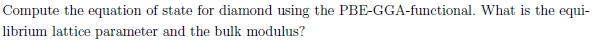

Plot for Graphene


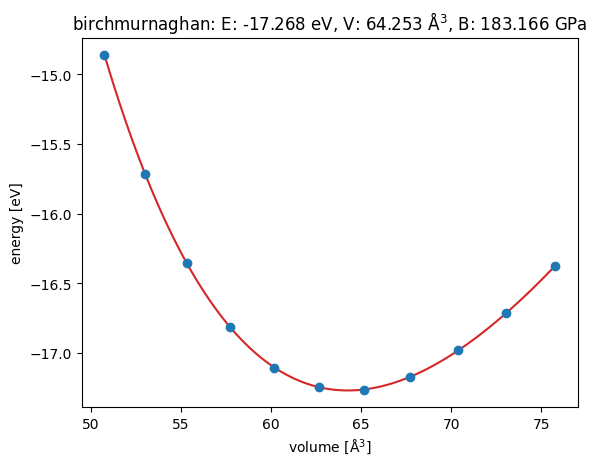

done for Graphene


In [48]:
V_dia, E_dia, eos_dia = calculate_eos_diamond()
print("done for Diamond")
V_grph, E_grph, eos_grph = calculate_eos_graphene()
print("done for Graphene")
V_grt, E_grt, eos_grt = calculate_eos_graphite()
print("done for Graphite")

### Load data from files if not in RAM

In [4]:
import pickle

mode = "load"
if mode == "load":
    load = True
    save = False
elif mode == "save":
    load = False
    save = True
else:
    load = save = False 

if save:
    with open('save/V_dia.pkl', 'wb') as file: 
        pickle.dump(V_dia, file) 
    with open('save/E_dia.pkl', 'wb') as file: 
        pickle.dump(E_dia, file) 
    with open('save/eos_dia.pkl', 'wb') as file: 
        pickle.dump(eos_dia, file) 

    with open('save/V_grt.pkl', 'wb') as file: 
        pickle.dump(V_grt, file) 
    with open('save/E_grt.pkl', 'wb') as file: 
        pickle.dump(E_grt, file) 
    with open('save/eos_grt.pkl', 'wb') as file: 
        pickle.dump(eos_grt, file) 

    with open('save/V_grph.pkl', 'wb') as file: 
        pickle.dump(V_grph, file) 
    with open('save/E_grph.pkl', 'wb') as file: 
        pickle.dump(E_grph, file) 
    with open('save/eos_grph.pkl', 'wb') as file: 
        pickle.dump(eos_grph, file) 

if load:
    with open('save/V_dia.pkl', 'rb') as file: 
        V_dia = pickle.load(file) 
    with open('save/E_dia.pkl', 'rb') as file: 
        E_dia = pickle.load(file) 
    with open('save/eos_dia.pkl', 'rb') as file: 
        eos_dia = pickle.load(file) 

    with open('save/V_grt.pkl', 'rb') as file: 
        V_grt = pickle.load(file) 
    with open('save/E_grt.pkl', 'rb') as file: 
        E_grt = pickle.load(file) 
    with open('save/eos_grt.pkl', 'rb') as file: 
        eos_grt = pickle.load(file) 

    with open('save/V_grph.pkl', 'rb') as file: 
        V_grph = pickle.load(file) 
    with open('save/E_grph.pkl', 'rb') as file: 
        E_grph = pickle.load(file) 
    with open('save/eos_grph.pkl', 'rb') as file: 
        eos_grph = pickle.load(file) 



### Results from Diamond

In [5]:
print(f"Diamond : V0 = {eos_dia[0]:.2f} Å^3, E0 = {eos_dia[1]:.2f} eV, B = {eos_dia[2] / kJ * 1.0e24:.2f} GPa")
print(f"The equilibrium lattice parameter is: a = {eos_dia[0]**(1/3):.3f}")

unit = gen_diamond()
supercell = unit * (3,3,3)
view(supercell, viewer='x3d')

Diamond : V0 = 45.37 Å^3, E0 = -68.28 eV, B = 475.04 GPa
The equilibrium lattice parameter is: a = 3.567


### Calculate Graphene

In [6]:
print(f"Graphene : V0 = {eos_grph[0]:.2f} Å^3, E0 = {eos_grph[1]:.2f} eV, B = {eos_grph[2] / kJ * 1.0e24:.2f} GPa")
z_spacing=10
print(f"The equilibrium lattice parameter is: a = {(eos_grph[0]/z_spacing)**(1/2):.3f}")

unit = gen_graphene()
supercell = unit * (3, 3, 3)
view(supercell, viewer='x3d')

Graphene : V0 = 64.25 Å^3, E0 = -17.27 eV, B = 183.17 GPa
The equilibrium lattice parameter is: a = 2.535


### Calculate Graphite

In [7]:
print(f"Graphite : V0 = {eos_grt[0]:.2f} Å^3, E0 = {eos_grt[1]:.2f} eV, B = {eos_grt[2] / kJ * 1.0e24:.2f} GPa")
print(f"The equilibrium lattice parameter is: a = {eos_grt[0]**(1/3):.3f} Å")

unit = gen_graphite()
supercell = unit* (3,3,2)
view(supercell, viewer='x3d')



Graphite : V0 = 83.61 Å^3, E0 = 245.25 eV, B = 10.61 GPa
The equilibrium lattice parameter is: a = 4.373 Å


In [8]:
unit = gen_graphite_from_poscar()
supercell = unit* (3,3,2)
view(supercell, viewer='x3d')


### C-C bond length

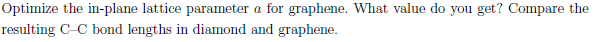

### Hexagonal Lattice Relationship

$V = \frac{\sqrt{3}}{2} a^2 c$

$ a = \sqrt{3} * d$

In [15]:
# diamond
# The lattice constant is 3.57 Å, and the C-C bond is 1.54 Å.

a_opt_dia = (eos_dia[0]) ** (1/3)  # Convert equilibrium volume to lattice constant for cubic structure
bond_length_dia = (np.sqrt(3) / 4) * a_opt_dia # Calculate the bond length
print(f"The equilibrium lattice parameter for diamond : a = {a_opt_dia:.3f}")
print(f'Carbon-carbon bond length for diamond : d = {bond_length_dia:.3f} Å')



# graphene
# The lattice constant a is 2.45 Å, and the C-C bond is 1.42 Å.
c=12
a_opt_graph = np.sqrt(2*eos_grph[0]/np.sqrt(3)/c) # Convert equilibrium volume to lattice constant, see formular above
bond_length_graph = a_opt_graph/np.sqrt(3) # Calculate the bond length
print(f"\nThe equilibrium lattice parameter for graphene : a = {a_opt_graph:.3f}")
print(f'Carbon-carbon bond length for graphene : {bond_length_graph:.3f} Å')


The equilibrium lattice parameter for diamond : a = 3.567
Carbon-carbon bond length for diamond : d = 1.544 Å

The equilibrium lattice parameter for graphene : a = 2.487
Carbon-carbon bond length for graphene : 1.436 Å


### Graphene in-plane parameter c

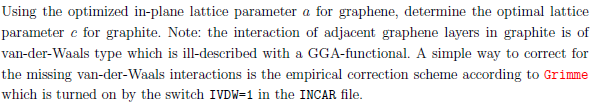

current c parameter: 6.03
current c parameter: 6.365
current c parameter: 6.7
current c parameter: 7.035
current c parameter: 7.370000000000001
current c parameter: 7.704999999999999
current c parameter: 8.04
Plot for Graphite


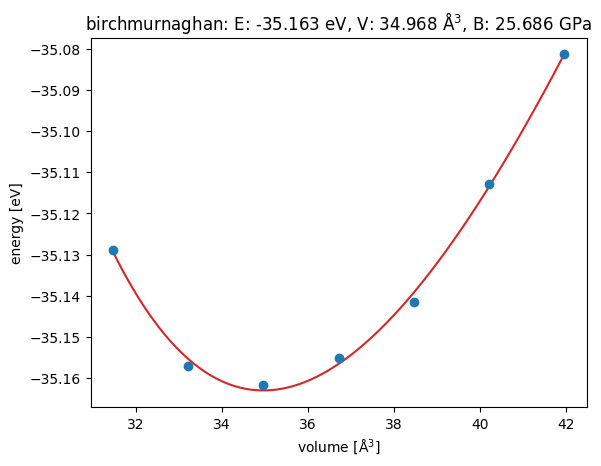

In [23]:

from dftd4.ase import DFTD4

def calculate_eos_graphite_grimme(a0=2.45,z_spacing=6.7, npoints=7):
    energies = []
    volumes = []
    for scale in np.linspace(0.9, 1.2, npoints):
        print("current c parameter: "+ str(z_spacing*scale))
        graphite_atoms = gen_graphite(c0=z_spacing*scale)
        calc_dft = GPAW(mode=PW(300), xc='PBE', kpts=(21,21,4), txt=f'save/graphite_c_opt_pw_{z_spacing*scale:.2f}.txt')        # calc with PW 
        graphite_atoms.calc = calc_dft
        energy = graphite_atoms.get_potential_energy()
        
        graphite_atoms_corr = gen_graphite(c0=z_spacing*scale)
        calc_corr = DFTD4(atoms=graphite_atoms,method="PBE",calculator=calc_dft)               # calc the vdW correction with DFTD4
        graphite_atoms_corr.calc = calc_corr
        energy_corr = graphite_atoms.get_potential_energy()        
        
        energies.append(energy+energy_corr)                             # add the correction
        volumes.append(graphite_atoms.get_volume()) 
        
    eos = EquationOfState(volumes, energies,eos='birchmurnaghan')
    eos_fit = eos.fit()
    print('Plot for Graphite')
    eos.plot('pics/Graphite_EOS.png')
    plt.show()
    return volumes,energies, eos_fit

V_grph_c, E_grph_c, eos_grph_c = calculate_eos_graphite_grimme()


In [24]:
a_graph = 2.45
c_graph = 2/np.sqrt(3)*eos_grph_c[0]/a_graph**2 # Convert equilibrium volume to lattice constant, see formular above
print(f"\nThe equilibrium distance between is: {c_graph:.3f}")
print(f"\nThe equilibrium lattice parameter for graphite between sheets is: c =  {c_graph/2:.3f}")


for PW only

The equilibrium distance between is: 6.727

The equilibrium lattice parameter for graphite between sheets is: c =  3.363


In [25]:
import pickle

mode = "save"
if mode == "load":
    load = True
    save = False
elif mode == "save":
    load = False
    save = True
else:
    load = save = False 

if save:
    with open('save/V_grph_c.pkl', 'wb') as file: 
        pickle.dump(V_grph_c, file) 
    with open('save/E_grph_c.pkl', 'wb') as file: 
        pickle.dump(E_grph_c, file) 
    with open('save/eos_grph_c.pkl', 'wb') as file: 
        pickle.dump(eos_grph_c, file) 

if load:
    with open('save/V_grph_c.pkl', 'rb') as file: 
        V_grph_c = pickle.load(file) 
    with open('save/E_grph_c.pkl', 'rb') as file: 
        E_grph_c = pickle.load(file) 
    with open('save/eos_grph_c.pkl', 'rb') as file: 
        eos_grph_c = pickle.load(file) 

# DOS

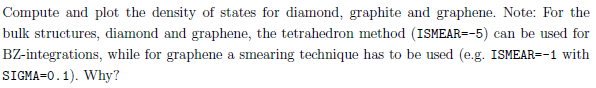

Why bradening <br>
Graphene, being a two-dimensional material with a relatively simple band structur, can have sharp features in its DOS. <br>
Without smearing, the DOS would show very sharp peaks, which are not realistic due to physical broadening mechanisms. <br>

/tmp/ipykernel_2448/1350368906.py:17: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)


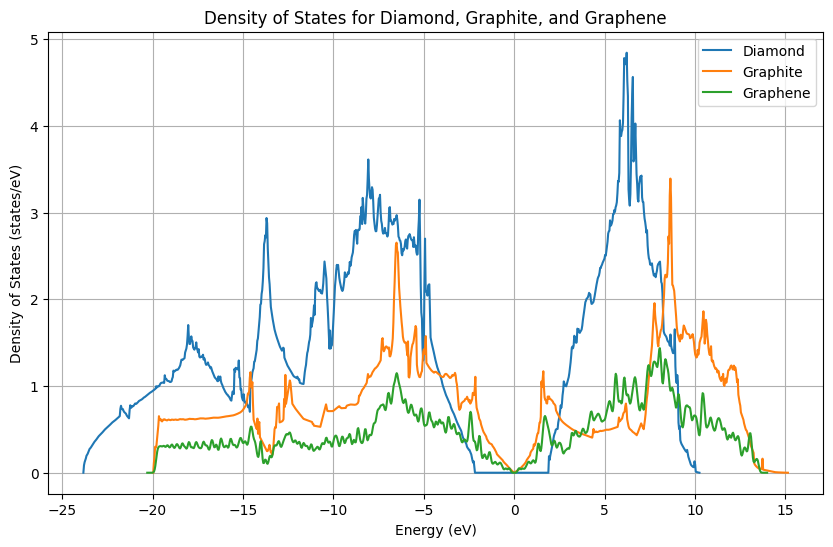

In [24]:
######
# class  ase.dft.dos.DOS(calc, width=0.1, window=None, npts=401, comm=<ase.parallel.MPI object>)
# Width of guassian smearing. Use width=0.0 for linear tetrahedron interpolation.
######

a_dia = 3.567
a_graph = 2.487
c_graph = 6.696




def compute_dos(atoms, kpts, ecut , width, name):

    calc = GPAW(mode=PW(ecut), xc='PBE', kpts=kpts, txt=None)

    atoms.set_calculator(calc)
    atoms.get_potential_energy()
    
    calc.write(name + '.gpw', 'all')
    calc = GPAW(name + '.gpw')
    
    dos = DOS(calc, npts=1000, width=width)
    energies = dos.get_energies()
    weights = dos.get_dos()
    
    return energies, weights

def plot_dos(energies, weights, label):
    plt.plot(energies, weights, label=label)


ecut = 300  
kpts_diamond = (18,18,18)
kpts_graphene = (30,30,1)
kpts_graphite = (21, 21, 4)



diamond = gen_diamond(a0=a_dia) 
energies_diamond, weights_diamond = compute_dos(diamond, kpts_diamond, ecut,0, 'diamond')

graphite = gen_graphite(a0=a_graph, c0=c_graph)
energies_graphite, weights_graphite = compute_dos(graphite, kpts_graphite, ecut,0, 'graphite')

graphene_sheet = graphene()
graphene_sheet.set_cell([graphene_sheet.cell[0], graphene_sheet.cell[1], [0, 0, 20]])
graphene_sheet.pbc = (True, True, False) # fixes the z axis 
energies_graphene, weights_graphene = compute_dos(graphene_sheet, kpts_graphene, ecut,0.1, 'graphene')

plt.figure(figsize=(10, 6))
plot_dos(energies_diamond, weights_diamond, 'Diamond')
plot_dos(energies_graphite, weights_graphite, 'Graphite')
plot_dos(energies_graphene, weights_graphene, 'Graphene')

plt.xlabel('Energy (eV)')
plt.ylabel('Density of States (states/eV)')
plt.legend()
plt.title('Density of States for Diamond, Graphite, and Graphene')
plt.grid()
plt.show()

# Band structure

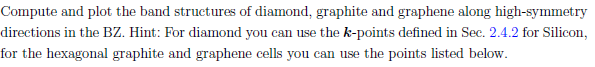

examples

Image(url='https://www.maxpierini.it/ncov/pics/ITA.png', width=200)

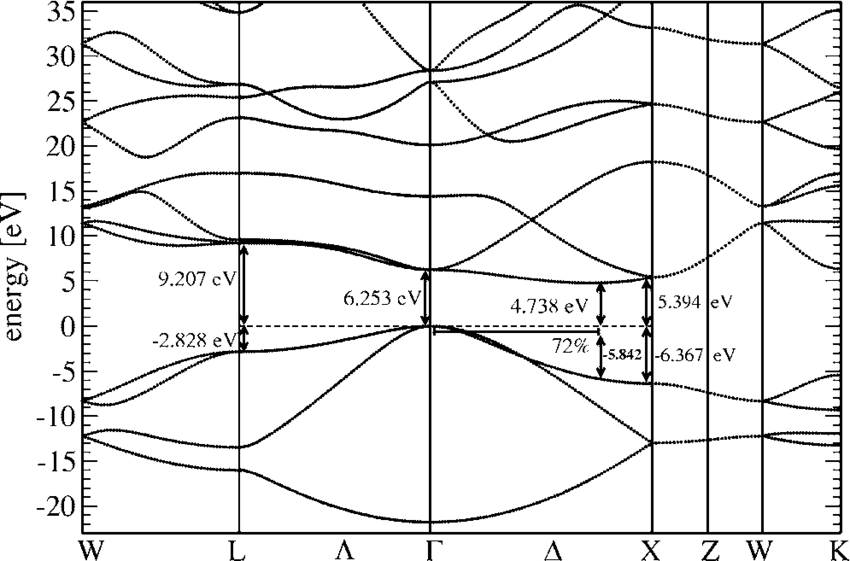

source [https://calzaferri.dcbp.unibe.ch/pdf/rr_JPC96.pdf]

Graphene / Graphite

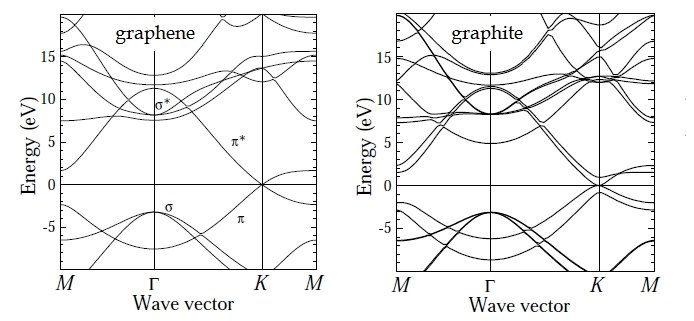

source [https://www.researchgate.net/figure/Electronic-band-structure-for-a-graphene-and-b-graphite-62_fig4_258435190]

In [6]:
def compute_band_structure(structure,kpts,points, npoints,name):
    calc_gs = GPAW(mode=PW(300),xc='PBE',kpts=kpts, txt=None)
    structure.calc = calc_gs
    structure.get_potential_energy()
    
    calc_gs.write(f'save/gs_{name}.gpw')

    #points= list(structure.cell.get_bravais_lattice().get_special_points().keys())
    #points.append("G") # symmetry

    band_path = bandpath(points, structure.cell, npoints=npoints)

    calc_bs = GPAW(f'save/gs_{name}.gpw',  # Restart from the ground state calculation
            kpts={'path': band_path.kpts, 'npoints': npoints},  # Define k-point path
            fixdensity=True,  # Use the density from the ground state
            symmetry='off',  # Turn off symmetry to avoid issues
            convergence={'bands': 8},  # maximum number of bands
            txt=f'save/band_struct_{name}.txt')
    
    calc_bs.get_potential_energy()
    bs = calc_bs.band_structure()
    bs = bs.subtract_reference() # 0 = fermit level
    return bs, band_path

# structure parameter
a_dia = 3.567
a_graph = 2.487
c_graph = 6.696


# k points for callculation
kpts_diamond = (18,18,18)
kpts_graphene = (30,30,1)
kpts_graphite = (21,21,4)

# k points for band structure calculation
npoints = 100



dia_points = ibz_points['fcc'] 
W = dia_points['W']
G = dia_points['Gamma']
X = dia_points['X']
L = dia_points['L']
K = dia_points['K']

graph_points = ibz_points['hexagonal']
Ag = graph_points['A']
Gg = graph_points['Gamma']
Mg = graph_points['M']
Kg = graph_points['K']


path_dia = [W, L, G, X, W, K]
path_dia_str = 'WLGXWK'
path_graphite = [Gg,Kg,Mg,Gg]
path_graphene = [Gg,Kg,Mg,Gg]
path_graph_str = 'G,K,M,G'



# generate atoms structures
diamond = gen_diamond(a0=a_dia) 
graphite = gen_graphite(a0=a_graph, c0=c_graph)

graphene_sheet = graphene()
graphene_sheet.set_cell([graphene_sheet.cell[0], graphene_sheet.cell[1], [0, 0, 20]])
graphene_sheet.pbc = (True, True, True) # needed to be set true for calculation

# Compute band structures
diamond_bs, diamond_bp = compute_band_structure(diamond,kpts_diamond,path_dia, npoints,'diamond')
graphite_bs, graphite_bp = compute_band_structure(graphite, kpts_graphite,path_graphite, npoints,'graphite')
graphene_bs, graphene_bp = compute_band_structure(graphene_sheet,kpts_graphene,path_graphene, npoints,'graphene')



/home/sebobo/.local/lib/python3.8/site-packages/gpaw/calculator.py:710: DeprecatedParameterWarning: The fixdensity keyword has been deprecated. Please use the GPAW.fixed_density() method instead.
  warnings.warn(


Diamond


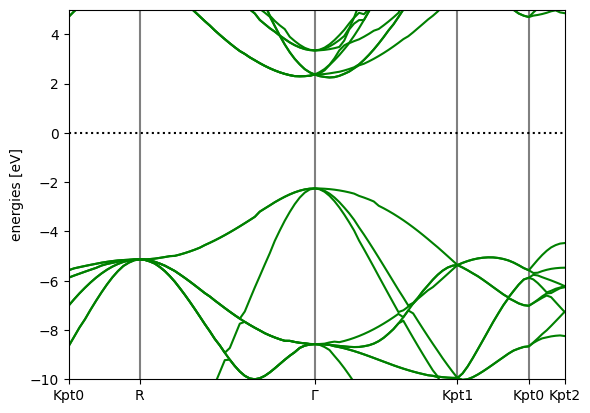

In [7]:
print("Diamond")
#diamond_bs.path.path=path_dia_str

fig = diamond_bs.plot(filename='pics/diamond_band_structure.png')
plt.show()

Graphite


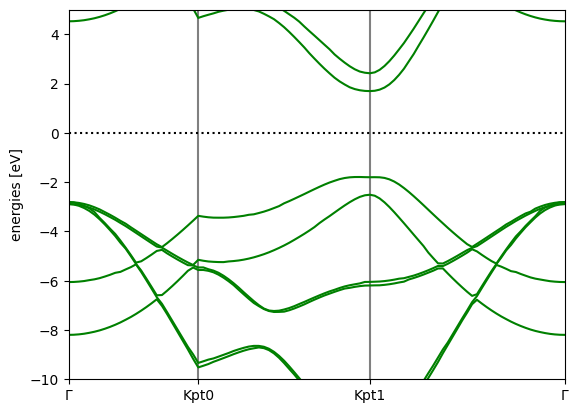

In [28]:
print("Graphite")
graphite_bs.path.path=path_graph_str
graphite_bs.plot(filename='pics/diamond_band_structure.png')
plt.show()

Graphene


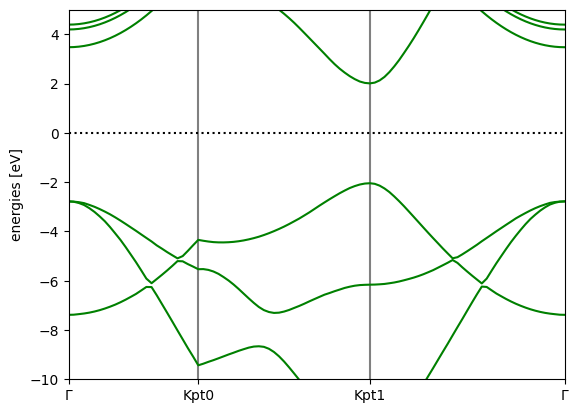

In [29]:
print("Graphene")
graphene_bs.plot(filename='pics/diamond_band_structure.png')
plt.show()

# Check for convergence of cutoff

/tmp/ipykernel_593/1588859993.py:12: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)


Cutoff energy: 100 eV, Total energy: 3.353073078406127 eV
Cutoff energy: 200 eV, Total energy: -45.21102167083496 eV
Cutoff energy: 300 eV, Total energy: -68.36838221826905 eV
Cutoff energy: 400 eV, Total energy: -71.94011529035383 eV
Cutoff energy: 500 eV, Total energy: -72.67720871910191 eV


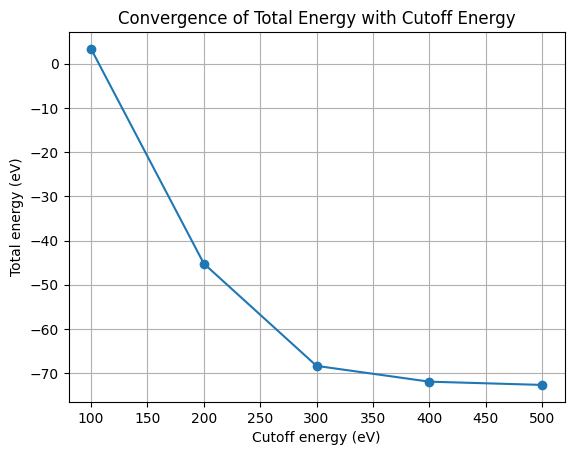

In [11]:
# Diamond

cutoff_energies = [100,200, 300, 400,500]
total_energies = []

atoms = gen_diamond()

# Perform calculations for each cutoff energy
for cutoff in cutoff_energies:
    calc = GPAW(mode=PW(cutoff),
                xc='PBE',
                kpts=(4, 4, 4),
                txt=f'gpaw_cutoff_{cutoff}.txt')
    atoms.set_calculator(calc)

    # Calculate the total energy
    total_energy = atoms.get_potential_energy()
    total_energies.append(total_energy)

    print(f'Cutoff energy: {cutoff} eV, Total energy: {total_energy} eV')


plt.figure()
plt.plot(cutoff_energies, total_energies, marker='o')
plt.xlabel('Cutoff energy (eV)')
plt.ylabel('Total energy (eV)')
plt.title('Convergence of Total Energy with Cutoff Energy')
plt.grid(True)
plt.show()

/tmp/ipykernel_593/4228273263.py:12: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)


Cutoff energy: 100 eV, Total energy: 0.5617362482478161 eV
Cutoff energy: 200 eV, Total energy: -22.232798424354645 eV
Cutoff energy: 300 eV, Total energy: -34.44823893546065 eV
Cutoff energy: 400 eV, Total energy: -36.4867747156793 eV
Cutoff energy: 500 eV, Total energy: -36.784503906139925 eV


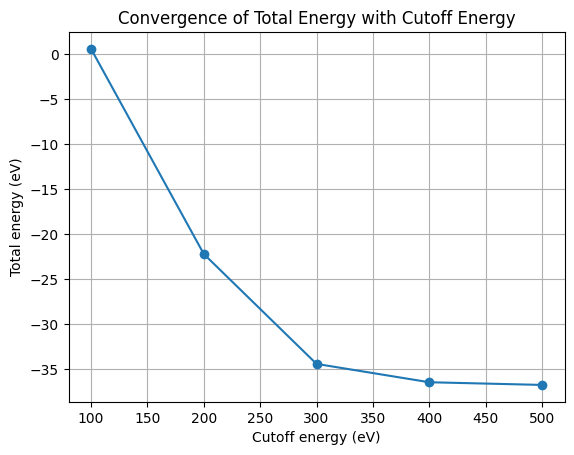

In [12]:
# Graphite

cutoff_energies = [100,200, 300, 400,500]
total_energies = []

atoms = gen_graphite()

# Perform calculations for each cutoff energy
for cutoff in cutoff_energies:
    calc = GPAW(mode=PW(cutoff),
                xc='PBE',
                kpts=(4, 4, 4),
                txt=f'gpaw_cutoff_{cutoff}.txt')
    atoms.set_calculator(calc)

    # Calculate the total energy
    total_energy = atoms.get_potential_energy()
    total_energies.append(total_energy)

    print(f'Cutoff energy: {cutoff} eV, Total energy: {total_energy} eV')


plt.figure()
plt.plot(cutoff_energies, total_energies, marker='o')
plt.xlabel('Cutoff energy (eV)')
plt.ylabel('Total energy (eV)')
plt.title('Convergence of Total Energy with Cutoff Energy')
plt.grid(True)
plt.show()

/tmp/ipykernel_593/3453372672.py:14: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)


Cutoff energy: 100 eV, Total energy: 0.24249094518434533 eV
Cutoff energy: 200 eV, Total energy: -11.121339471759018 eV
Cutoff energy: 300 eV, Total energy: -17.243861138713623 eV
Cutoff energy: 400 eV, Total energy: -18.267915669464937 eV
Cutoff energy: 500 eV, Total energy: -18.417032660778645 eV


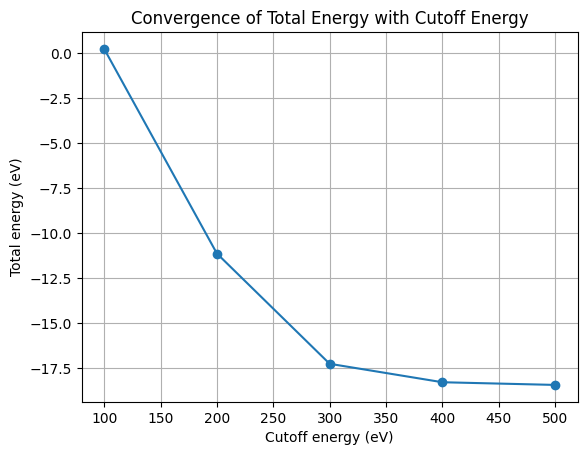

In [19]:
# Graphene

cutoff_energies = [100,200, 300, 400,500]
total_energies = []

atoms = gen_graphene()

# Perform calculations for each cutoff energy
for cutoff in cutoff_energies:
    calc = GPAW(mode=PW(cutoff),
                xc='PBE',
                kpts=(4, 4, 4),
                txt=f'gpaw_cutoff_{cutoff}.txt')
    atoms.set_calculator(calc)

    # Calculate the total energy
    total_energy = atoms.get_potential_energy()
    total_energies.append(total_energy)

    print(f'Cutoff energy: {cutoff} eV, Total energy: {total_energy} eV')


plt.figure()
plt.plot(cutoff_energies, total_energies, marker='o')
plt.xlabel('Cutoff energy (eV)')
plt.ylabel('Total energy (eV)')
plt.title('Convergence of Total Energy with Cutoff Energy')
plt.grid(True)
plt.show()